# Filtering and Thresholding Design Parameters

While cheap gradients are always appreciated, we may have noticed that the optimizer and adjoint solver often produce devices that are impossible to fabricate. They tend to contain continuosly varying refractive indices or small feature sizes. Furthermore, the lack of constraint often throws the optimizer into local minima, stunting the overall progress of the solver.

To overcome this, the Topology Optimization (TO) community often implements linear and nonlinear functional transforms on the design parameters before projecting them onto the simulation domain. For example, we can blur many of the small design parameters together using a gaussian filter, and subsequently threshold using sigmoid like functions.

The resulting parameters can include constraints, like minimum lengths scales, and project the cost function into a more friendly (and sometimes less friendly) design space.

We'll examine how to accomplish these goals using native `autograd` functions and meep's adjoint solver.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import grad, jacobian
import nlopt
from matplotlib import pyplot as plt
from scipy import special, signal
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


As before, we'll generate our simulation cell with the specified sources, boundary layers, geometry, etc. Except this time, we'll randomly generate our design variables from 0 to 1 (rather than 1 to 12 as before).

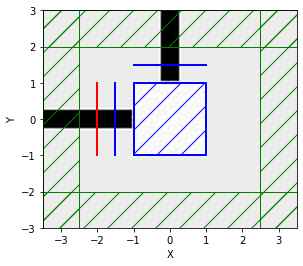

In [2]:
resolution = 20

design_region_width = 2
design_region_height = 2
design_region_resolution = int(2.5*resolution)

Nx = design_region_resolution * design_region_width
Ny = design_region_resolution * design_region_height

Sx = 7
Sy = 6
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-2,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

seed = 24*2
np.random.seed(seed)

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0))
rho_vector = np.random.rand(Nx*Ny)
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1.5,0),size=mp.Vector3(x=2)),mode=1)
TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(-1.5,0,0),size=mp.Vector3(y=2)),mode=1)
ob_list = [TE_top,TE0]

def J(top,source):
    return npa.abs(top/source) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df=0,
    nf=1,
    decay_fields=[mp.Ez]
)

opt.plot2D(True)
plt.show()

Next, we'll define various filters that perfrom smoothing, projection, and material scaling. We'll be sure to use autograd so that we can easily backpropogate our gradient provided by the adjoint solver.

In [3]:
def material_scaling(x):
    return 11*x + 1
def mapping(x,sigma,delta,beta):
    return material_scaling(mpa.projection_filter(mpa.smoothing_filter(x,sigma,delta,Nx,Ny),sigma,delta,beta))

Next, let's see how well our filtering and projection functions work.

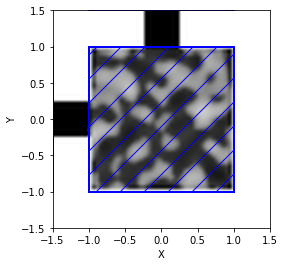

In [4]:
opt.update_design([mapping(rho_vector,4,0,8)])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.show()

We can increase our `beta` term, which controls the thresholding, and simultaneously sweep our perturbation term (`delta`) which is used to generate erosion and dilation geometries typically used in the literature. 

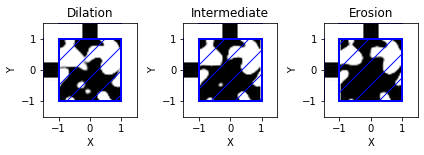

In [5]:
beta = 2048

plt.figure()
ax1 = plt.subplot(1,3,1)
opt.update_design([mapping(rho_vector,8,-0.01,beta)])
opt.plot2D(True,ax=ax1,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Dilation")

ax2 = plt.subplot(1,3,2)
opt.update_design([mapping(rho_vector,8,0,beta)])
opt.plot2D(True,ax=ax2,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Intermediate")

ax3 = plt.subplot(1,3,3)
opt.update_design([mapping(rho_vector,8,0.01,beta)])
opt.plot2D(True,ax=ax3,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Erosion")

plt.tight_layout()
plt.show()

With our framwork in place, we can define our `nlopt` cost function wrapper that also includes our mapping layers and their corresponding gradients. We'll systematically increase our `beta` term so that the thresholding gradually turns on, as suggested by the literature.

In [6]:
evaluation_history = []
iter = 0
beta = 1
sigma = 4
delta = 0
final_inputs = np.zeros((Nx*Ny,))
def f(x, grad):
    global beta
    global iter
    f0, dJ_deps, dg = opt([mapping(x,sigma,delta,beta)])
    if grad.size > 0:
        dJ_drhobar = np.squeeze(design_variables.get_basis_vjp(dJ_deps,dg))
        grad[:] = jacobian(mapping,0)(dJ_drhobar,sigma,delta,beta)@dJ_drhobar
    evaluation_history.append(np.real(f0))
    if iter % 10 == 0:
        beta = beta * 1.2
    iter+=1
    final_inputs[:] = x
    return np.real(f0)

We'll now run our optimizer

In [7]:
algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 50

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)
init = rho_vector*0 + 0.5
x = solver.optimize(rho_vector)

[0.01749027 0.89157327 0.28486117 ... 0.09208504 0.40353651 0.54678462]
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating grad

And visualize the results. We see that every time `beta` increases it's slightly harder for the solver to improve. This is expected as the gradient starts to swing wildy at these thresholded transition regions. Regardless, we are still able to generate a somewhat smoothed structure after just 30 iterations.

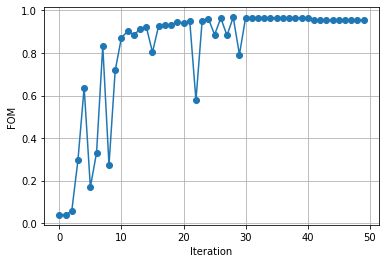

In [8]:
plt.figure()
plt.plot(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

To be sure, we can plot our results and see the resulting geometry. In practice, we would want to run the optimizer for much longer change `beta` less frequently/drastically.

2.48832
0.9679610025492219


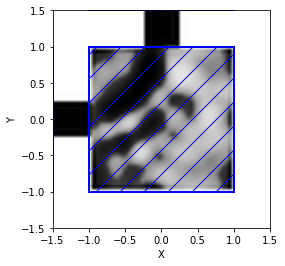

In [9]:
print(beta)
opt_val = solver.last_optimum_value()
print(opt_val)
opt.update_design([mapping(final_inputs,sigma,delta,beta)])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.show()

In summary, it is very easy to implement design constraints and density parameter operations using the native adjoint solver interface.